##### Copyright 2024 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Intro to Autoencoders

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/autoencoder">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/autoencoder.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/autoencoder.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/autoencoder.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial introduces autoencoders with three examples: the basics, image denoising, and anomaly detection.

An autoencoder is a special type of neural network that is trained to copy its input to its output. For example, given an image of a handwritten digit, an autoencoder first encodes the image into a lower dimensional latent representation, then decodes the latent representation back to an image. An autoencoder learns to compress the data while minimizing the reconstruction error.

To learn more about autoencoders, please consider reading chapter 14 from [Deep Learning](https://www.deeplearningbook.org/) by Ian Goodfellow, Yoshua Bengio, and Aaron Courville.

## Import TensorFlow and other libraries

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as im
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

#from PIL import Image
import skimage

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
code_path = '/content/drive/MyDrive/Colab Notebooks/BENG 280C Final Project/'

train_path_NOISY = '/content/drive/MyDrive/CT_database/Train_NEW_NOISY/'
train_path_DL = '/content/drive/MyDrive/CT_database/Train_NEW_DL/'
test_path_NOISY = '/content/drive/MyDrive/CT_database/Test_NEW_NOISY/' #CHANGE TO TEST
test_path_DL = '/content/drive/MyDrive/CT_database/Test_NEW_DL/' #CHANGE TO TEST

## Load the dataset
To start, you will train the basic autoencoder using the Fashion MNIST dataset. Each image in this dataset is 28x28 pixels.

In [ ]:
#(x_train, _), (x_test, _) = fashion_mnist.load_data()

import cv2
import os

x_train_big = []
x_test_big = []

x_train = []
x_test = []

# Load in the images
for filepath in sorted(os.listdir(train_path_DL)):
    x_train_big.append(cv2.imread(train_path_DL+filepath, cv2.IMREAD_GRAYSCALE))
    #print(train_path_DL + filepath)

for filepath in sorted(os.listdir(test_path_DL)):
    x_test_big.append(cv2.imread(test_path_DL+filepath, cv2.IMREAD_GRAYSCALE))
    #print(test_path_DL + filepath)

print(x_train_big[1].dtype)
print (x_train_big[1].shape)
#print(len(x_train_big))

r = range(120,428, 28)
for i in x_train_big:
    for j in range(10):
        x_train.append(i[r[j]:r[j+1],r[j]:r[j+1]])

for i in x_test_big:
    for j in range(10):
        x_test.append(i[r[j]:r[j+1],r[j]:r[j+1]])



x_train = np.asarray(x_train)
x_test = np.asarray(x_test)
print (x_train.shape)
print (x_test.shape)

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

#print (x_train[1, 18, 18])

uint8
(512, 512)
(3420, 28, 28)
(1710, 28, 28)


In [ ]:
x = x_train_big[5][120:256, 120:256]
#print(x)
print (x_train[1700])
print (x_train[1700].shape)
#print (x_train[3].dtype)

[[0.34117648 0.34117648 0.4        0.42352942 0.42352942 0.44313726
  0.44313726 0.42352942 0.4        0.42352942 0.44313726 0.44313726
  0.42352942 0.4        0.38039216 0.38039216 0.38039216 0.4
  0.4        0.38039216 0.36078432 0.36078432 0.38039216 0.4
  0.42352942 0.42352942 0.4        0.36078432]
 [0.3254902  0.3254902  0.36078432 0.38039216 0.4        0.42352942
  0.42352942 0.4        0.4        0.4        0.42352942 0.42352942
  0.38039216 0.38039216 0.38039216 0.36078432 0.36078432 0.38039216
  0.4        0.4        0.4        0.38039216 0.4        0.42352942
  0.42352942 0.42352942 0.4        0.36078432]
 [0.30588236 0.3254902  0.36078432 0.38039216 0.38039216 0.38039216
  0.38039216 0.36078432 0.36078432 0.38039216 0.38039216 0.38039216
  0.38039216 0.38039216 0.38039216 0.36078432 0.36078432 0.38039216
  0.38039216 0.4        0.4        0.4        0.4        0.42352942
  0.42352942 0.42352942 0.4        0.4       ]
 [0.34117648 0.36078432 0.38039216 0.4        0.38039216 

In [ ]:
class Autoencoder(Model):
  def __init__(self, latent_dim, shape):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(tf.math.reduce_prod(shape).numpy(), activation='sigmoid'),
      layers.Reshape(shape)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


#shape = x_test.shape[1:]
shape = x_train.shape[1:]
latent_dim = 64 #256
autoencoder = Autoencoder(latent_dim, shape)


In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

Train the model using `x_train` as both the input and the target. The `encoder` will learn to compress the dataset from 784 dimensions to the latent space, and the `decoder` will learn to reconstruct the original images.
.

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

#autoencoder.fit(x_train, x_train,
#                epochs=10,
#                shuffle=True,
#                validation_data=(x_test, x_test))

Epoch 1/10
107/107 [==============================] - 1s 6ms/step - loss: 0.0691 - val_loss: 0.0514
Epoch 2/10
107/107 [==============================] - 0s 4ms/step - loss: 0.0265 - val_loss: 0.0312
Epoch 3/10
107/107 [==============================] - 1s 5ms/step - loss: 0.0123 - val_loss: 0.0201
Epoch 4/10
107/107 [==============================] - 1s 6ms/step - loss: 0.0088 - val_loss: 0.0221
Epoch 5/10
107/107 [==============================] - 1s 7ms/step - loss: 0.0075 - val_loss: 0.0186
Epoch 6/10
107/107 [==============================] - 1s 6ms/step - loss: 0.0059 - val_loss: 0.0161
Epoch 7/10
107/107 [==============================] - 1s 7ms/step - loss: 0.0054 - val_loss: 0.0125
Epoch 8/10
107/107 [==============================] - 1s 8ms/step - loss: 0.0047 - val_loss: 0.0143
Epoch 9/10
107/107 [==============================] - 1s 6ms/step - loss: 0.0042 - val_loss: 0.0101
Epoch 10/10
107/107 [==============================] - 1s 5ms/step - loss: 0.0037 - val_loss: 0.0096

Now that the model is trained, let's test it by encoding and decoding images from the test set.

In [ ]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

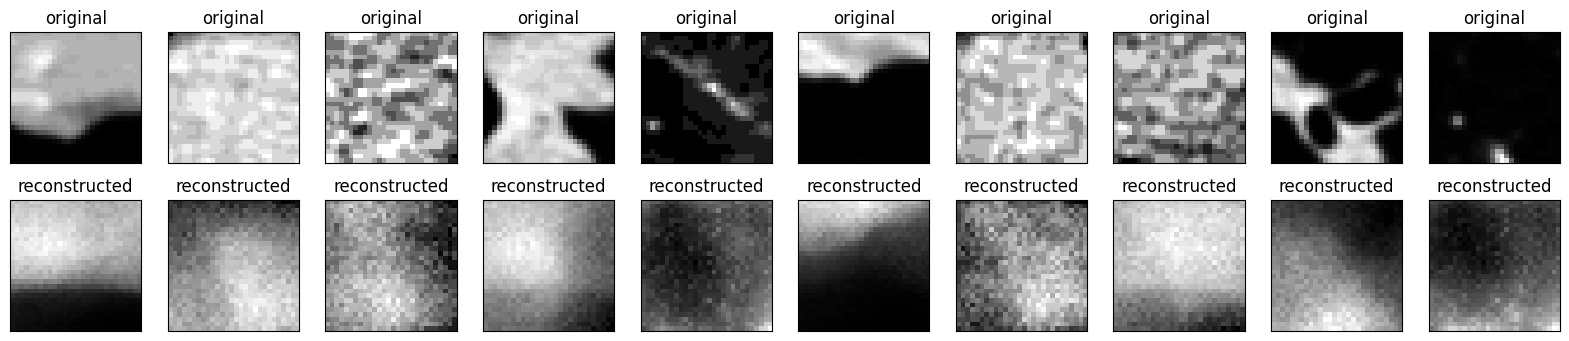

In [ ]:
n=10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i*32])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i*32])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## Second example: Image denoising


![Image denoising results](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/image_denoise_fmnist_results.png?raw=1)

An autoencoder can also be trained to remove noise from images. In the following section, you will create a noisy version of the Fashion MNIST dataset by applying random noise to each image. You will then train an autoencoder using the noisy image as input, and the original image as the target.

Let's reimport the dataset to omit the modifications made earlier.

In [ ]:
#(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [ ]:
import cv2
import os

# Load in DL Test/Train

x_train_big = []
x_test_big = []

x_train = []
x_test = []


for filepath in sorted(os.listdir(train_path_DL)):
    x_train_big.append(cv2.imread(train_path_DL+filepath, cv2.IMREAD_GRAYSCALE))

for filepath in sorted(os.listdir(test_path_DL)):
    x_test_big.append(cv2.imread(test_path_DL+filepath, cv2.IMREAD_GRAYSCALE))

r = range(120,428, 28)
for i in x_train_big:
    for j in range(10):
      for k in range(10):
        x_train.append(i[r[j]:r[j+1],r[k]:r[k+1]])

for i in x_test_big:
    for j in range(10):
      for k in range(10):
        x_test.append(i[r[j]:r[j+1],r[k]:r[k+1]])



x_train = np.asarray(x_train)
x_test = np.asarray(x_test)
print (x_train.shape)
print (x_test.shape)

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.


# Load in Noisy Test/Train
x_train_noisy_big = []
x_test_noisy_big = []

x_train_noisy = []
x_test_noisy = []


for filepath in sorted(os.listdir(train_path_NOISY)):
    x_train_noisy_big.append(cv2.imread(train_path_NOISY+filepath, cv2.IMREAD_GRAYSCALE))
    #print(train_path_NOISY + filepath)

for filepath in sorted(os.listdir(test_path_NOISY)):
    x_test_noisy_big.append(cv2.imread(test_path_NOISY+filepath, cv2.IMREAD_GRAYSCALE))

r = range(120,428, 28)
for i in x_train_noisy_big:
    for j in range(10):
      for k in range(10):
        x_train_noisy.append(i[r[j]:r[j+1],r[k]:r[k+1]])

for i in x_test_noisy_big:
    for j in range(10):
      for k in range(10):
        x_test_noisy.append(i[r[j]:r[j+1],r[k]:r[k+1]])

x_train_noisy = np.asarray(x_train_noisy)
x_test_noisy = np.asarray(x_test_noisy)

x_train_noisy = x_train_noisy.astype('float32') / 255.
x_test_noisy = x_test_noisy.astype('float32') / 255.

#print (x_train[1, 18, 18])

(34200, 28, 28)
(17100, 28, 28)


Produce Lowpass Reference Image


In [ ]:
x_lowpass = []
for i in x_test_noisy:
  x_lowpass.append(skimage.filters.gaussian(i, sigma=.7))

x_lowpass_big = []
for i in x_test_noisy_big:
  x_lowpass_big.append(skimage.filters.gaussian(i, sigma=.7))

Plot the noisy images.


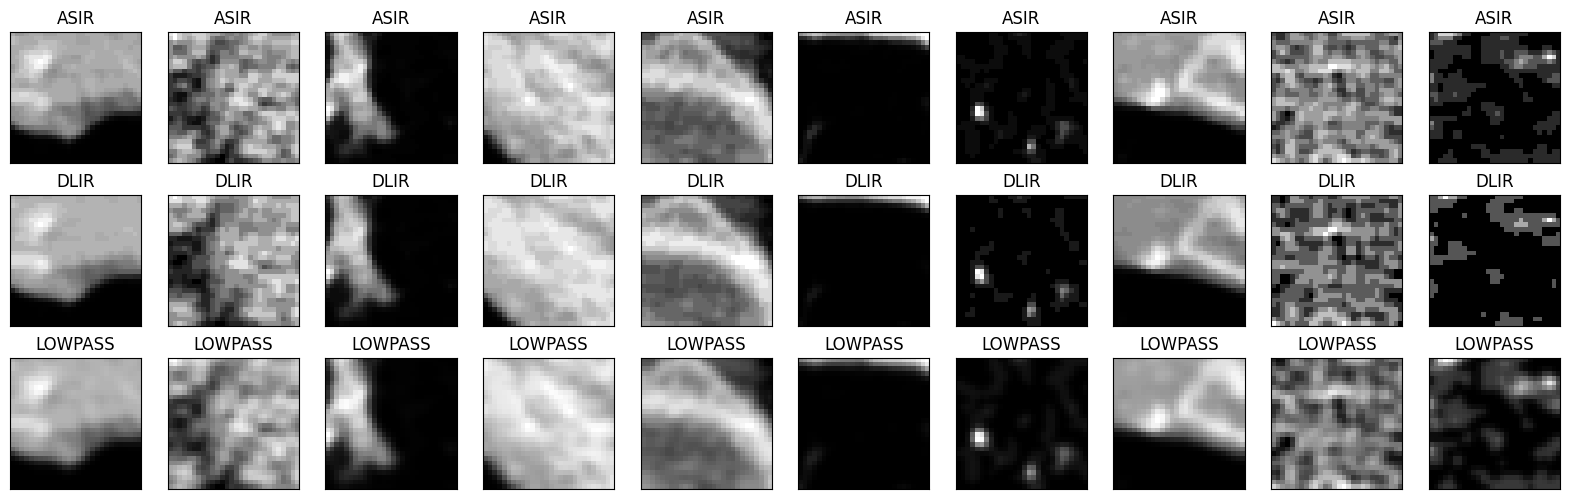

In [ ]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
  # display original
  ax = plt.subplot(3, n, i + 1)
  plt.imshow(x_test_noisy[i*43])
  plt.title("ASIR")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(3, n, i + 1 + n)
  plt.imshow(x_test[i*43])
  plt.title("DLIR")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  #display low pass (Gaussian Blur)
  ax = plt.subplot(3, n, i + 1 + 2*n)
  plt.imshow(x_lowpass[i*43])
  plt.title("LOWPASS")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

### Define a convolutional autoencoder

In this example, you will train a convolutional autoencoder using  [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) layers in the `encoder`, and [Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) layers in the `decoder`.

In [ ]:
k = 3
@tf.keras.utils.register_keras_serializable('my_package')
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, (k, k), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (k, k), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=k, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=k, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(k, k), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
#autoencoder.fit(x_train_noisy, x_train,
#                epochs=10,
#                shuffle=True,
#                validation_data=(x_test_noisy, x_test))

autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))
autoencoder.save(code_path + 'auto_model.keras')

Epoch 1/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0212 - val_loss: 8.9212e-04
Epoch 2/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 6.6504e-04 - val_loss: 5.6398e-04
Epoch 3/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 4.3725e-04 - val_loss: 4.4242e-04
Epoch 4/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 3.5796e-04 - val_loss: 3.9681e-04
Epoch 5/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 3.0554e-04 - val_loss: 3.3165e-04
Epoch 6/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 2.6706e-04 - val_loss: 2.7811e-04
Epoch 7/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 2.1702e-04 - val_loss: 2.3336e-04
Epoch 8/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 1.9125e-04 - val_loss: 2.1164e-04
Epoch 9/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 1.7118e-04 - val_loss: 1.9463e-04
Epoch 10/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 1.6487e-04 - val_loss: 1.8358e-04


In [ ]:
#autoencoder.save(code_path + 'auto_model.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_api.py:102: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


Let's take a look at a summary of the encoder. Notice how the images are downsampled from 28x28 to 7x7.

In [ ]:
autoencoder.encoder.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 14, 14, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 8)             │           1,160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,320 (5.16 KB)

 Trainable params: 1,320 (5.16 KB)

 Non-trainable params: 0 (0.00 B)

The decoder upsamples the images back from 7x7 to 28x28.

In [ ]:
autoencoder.decoder.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 1)           │             145 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,897 (7.41 KB)

 Trainable params: 1,897 (7.41 KB)

 Non-trainable params: 0 (0.00 B)

Plotting both the noisy images and the denoised images produced by the autoencoder.

In [ ]:
autoencoder = tf.keras.models.load_model(code_path + 'auto_model.keras')
autoencoder.summary()

TypeError: <class '__main__.Denoise'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': None, 'class_name': 'Denoise', 'config': {'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}}, 'registered_name': 'my_package>Denoise', 'build_config': {'input_shape': [None, 28, 28]}, 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'Adam', 'config': {'name': 'adam', 'learning_rate': 0.0010000000474974513, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}, 'registered_name': None}, 'loss': {'module': 'keras.losses', 'class_name': 'MeanSquaredError', 'config': {'name': 'mean_squared_error', 'reduction': 'sum_over_batch_size'}, 'registered_name': None}, 'loss_weights': None, 'metrics': None, 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': True}}.

Exception encountered: Unable to revive model from config. When overriding the `get_config()` method, make sure that the returned config contains all items used as arguments in the  constructor to <class '__main__.Denoise'>, which is the default behavior. You can override this default behavior by defining a `from_config(cls, config)` class method to specify how to create an instance of Denoise from its config.

Received config={'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}}

Error encountered during deserialization: Denoise.__init__() got an unexpected keyword argument 'trainable'

In [ ]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

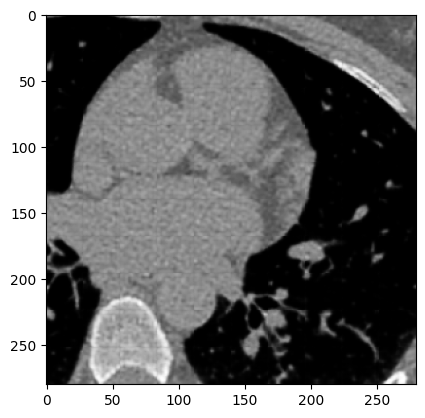

In [ ]:
#decoded_imgs = tf.squeeze(decoded_imgs)

x_test_recon = []
#print(len(x_test_big))
for i in range(len(x_test_big)):
  x_row = []
  for j in range(10):
    x_pic = []
    for k in range(10):
      x_pic.append(decoded_imgs[i*100 + j*10 + k]) #jth chunk within image i
    x_row.append(np.hstack(x_pic))
# Stack the chunks horizontally to reconstruct the image
  x_test_recon.append(np.vstack(x_row))

plt.imshow(tf.squeeze(x_test_recon[43]), cmap='gray')

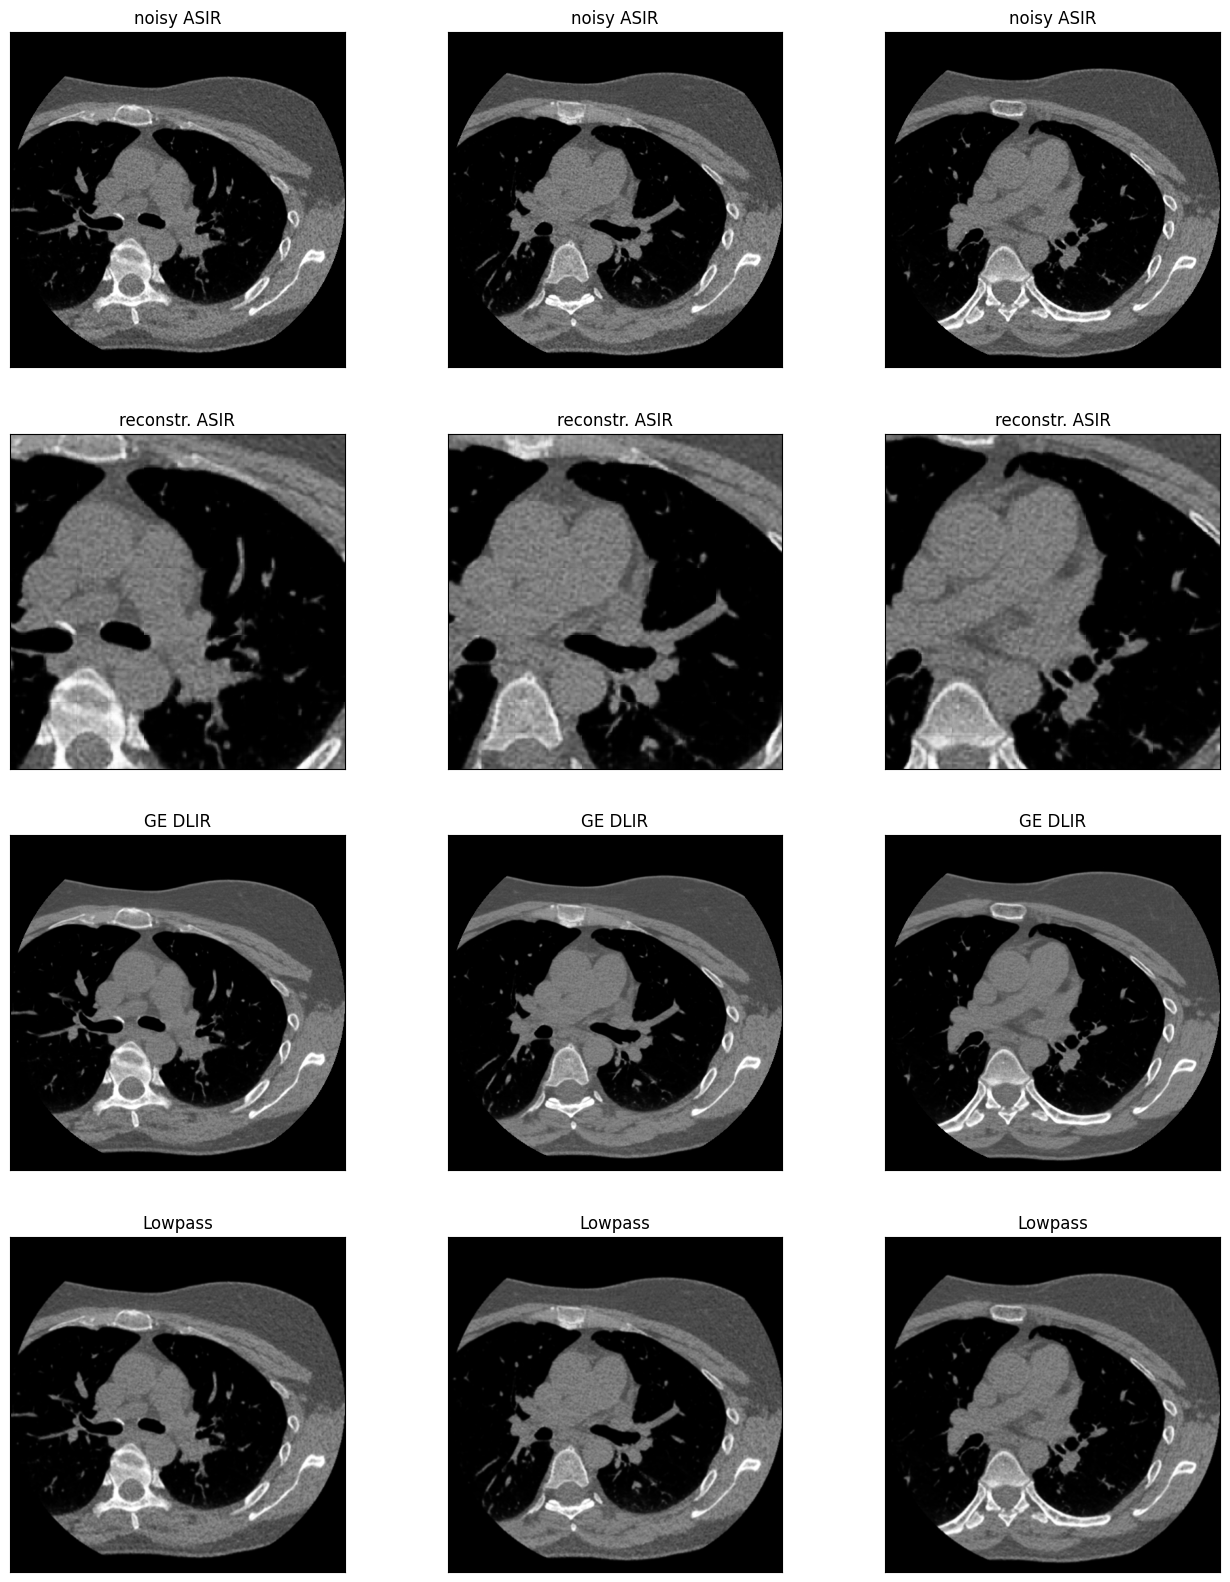

In [ ]:
#Plot Reconstructed Images
n = 3
index = 12
plt.figure(figsize=(16, 20))
for i in range(n):

    #noisy ASIR, ASIR after autencdoer, lowpass, GE DLIR
    # display original + noise
    ax = plt.subplot(4, n, i + 1)
    plt.title("noisy ASIR")
    plt.imshow(tf.squeeze(x_test_noisy_big[i*index]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(4, n, i + n + 1)
    plt.title("ASIR after Autoencoder")
    plt.imshow(tf.squeeze(x_test_recon[i*index]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

    # display target
    bx = plt.subplot(4, n, i + 2*n + 1)
    plt.title("GE DLIR")
    plt.imshow(tf.squeeze(x_test_big[i*index]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

    # display target
    bx = plt.subplot(4, n, i + 3*n + 1)
    plt.title("Lowpass")
    plt.imshow(tf.squeeze(x_lowpass_big[i*index]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

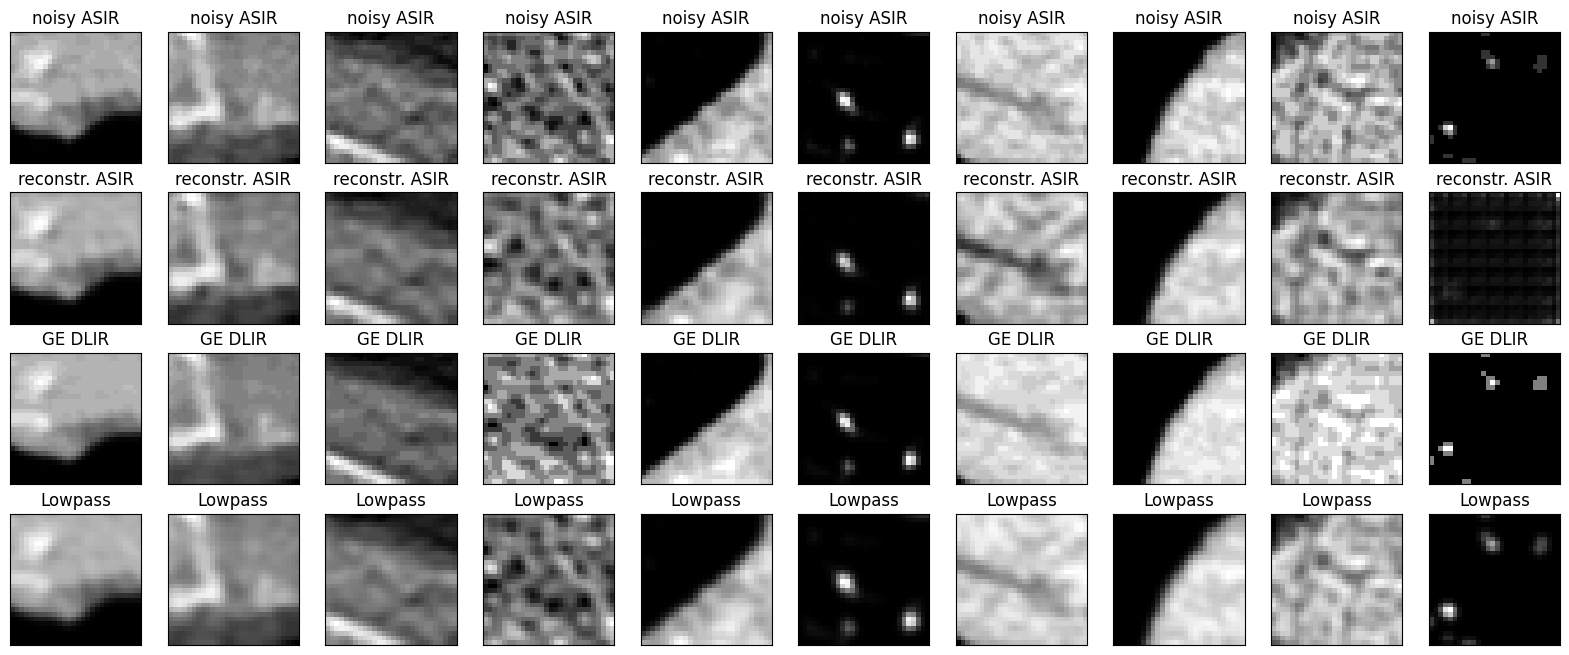

In [ ]:
#Plot Small Chunks
#nums = 32, 42, 43
n = 10
index = 203
plt.figure(figsize=(20, 8))
for i in range(n):

    # display original + noise
    ax = plt.subplot(4, n, i + 1)
    plt.title("noisy ASIR")
    plt.imshow(tf.squeeze(x_test_noisy[i*index]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(4, n, i + n + 1)
    plt.title("reconstr. ASIR")
    plt.imshow(tf.squeeze(decoded_imgs[i*index]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

    # display target
    bx = plt.subplot(4, n, i + 2*n + 1)
    plt.title("GE DLIR")
    plt.imshow(tf.squeeze(x_test[i*index]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

    # display target
    bx = plt.subplot(4, n, i + 3*n + 1)
    plt.title("Lowpass")
    plt.imshow(tf.squeeze(x_lowpass[i*index]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

## Third example: Anomaly detection

## Overview


In this example, you will train an autoencoder to detect anomalies on the [ECG5000 dataset](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000). This dataset contains 5,000 [Electrocardiograms](https://en.wikipedia.org/wiki/Electrocardiography), each with 140 data points. You will use a simplified version of the dataset, where each example has been labeled either `0` (corresponding to an abnormal rhythm), or `1` (corresponding to a normal rhythm). You are interested in identifying the abnormal rhythms.

Note: This is a labeled dataset, so you could phrase this as a supervised learning problem. The goal of this example is to illustrate anomaly detection concepts you can apply to larger datasets, where you do not have labels available (for example, if you had many thousands of normal rhythms, and only a small number of abnormal rhythms).

How will you detect anomalies using an autoencoder? Recall that an autoencoder is trained to minimize reconstruction error. You will train an autoencoder on the normal rhythms only, then use it to reconstruct all the data. Our hypothesis is that the abnormal rhythms will have higher reconstruction error. You will then classify a rhythm as an anomaly if the reconstruction error surpasses a fixed threshold.

### Load ECG data

The dataset you will use is based on one from [timeseriesclassification.com](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000).


In [ ]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

In [ ]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

Normalize the data to `[0,1]`.


In [ ]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

You will train the autoencoder using only the normal rhythms, which are labeled in this dataset as `1`. Separate the normal rhythms from the abnormal rhythms.

In [ ]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

Plot a normal ECG.

In [ ]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

Plot an anomalous ECG.

In [ ]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

### Build the model

In [ ]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [ ]:
autoencoder.compile(optimizer='adam', loss='mae')

Notice that the autoencoder is trained using only the normal ECGs, but is evaluated using the full test set.

In [ ]:
history = autoencoder.fit(normal_train_data, normal_train_data,
          epochs=20,
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

You will soon classify an ECG as anomalous if the reconstruction error is greater than one standard deviation from the normal training examples. First, let's plot a normal ECG from the training set, the reconstruction after it's encoded and decoded by the autoencoder, and the reconstruction error.

In [ ]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Create a similar plot, this time for an anomalous test example.

In [ ]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### Detect anomalies

Detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold. In this tutorial, you will calculate the mean average error for normal examples from the training set, then classify future examples as anomalous if the reconstruction error is higher than one standard deviation from the training set.


Plot the reconstruction error on normal ECGs from the training set

In [ ]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

Choose a threshold value that is one standard deviations above the mean.

In [ ]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Note: There are other strategies you could use to select a threshold value above which test examples should be classified as anomalous, the correct approach will depend on your dataset. You can learn more with the links at the end of this tutorial.

If you examine the reconstruction error for the anomalous examples in the test set, you'll notice most have greater reconstruction error than the threshold. By varing the threshold, you can adjust the [precision](https://developers.google.com/machine-learning/glossary#precision) and [recall](https://developers.google.com/machine-learning/glossary#recall) of your classifier.

In [ ]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

Classify an ECG as an anomaly if the reconstruction error is greater than the threshold.

In [ ]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [ ]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

## Next steps

To learn more about anomaly detection with autoencoders, check out this excellent [interactive example](https://anomagram.fastforwardlabs.com/#/) built with TensorFlow.js by Victor Dibia. For a real-world use case, you can learn how [Airbus Detects Anomalies in ISS Telemetry Data](https://blog.tensorflow.org/2020/04/how-airbus-detects-anomalies-iss-telemetry-data-tfx.html) using TensorFlow. To learn more about the basics, consider reading this [blog post](https://blog.keras.io/building-autoencoders-in-keras.html) by François Chollet. For more details, check out chapter 14 from [Deep Learning](https://www.deeplearningbook.org/) by Ian Goodfellow, Yoshua Bengio, and Aaron Courville.
